# Trabajo Práctico N°2 - Visión por Computadora I
---

Autora:
* Pryszczuk, Sabrina Daiana (a2226)

## Importación de Librerías
---

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, fftshift
import os

# Configuración de estilos para los gráficos
plt.style.use('seaborn-v0_8-whitegrid') 

## Definición de las Métricas (*Paper* 1 y *Paper* 2)
---

In [2]:
def calcular_metric_fourier(imagen):
    """
    Implemento la métrica de nitidez en el dominio de la frecuencia.
    Basado en: 'Image Sharpness Measure for Blurred Images in Frequency Domain'.
    """
    # Si la imagen es color, la convierto a escala de grises
    if len(imagen.shape) == 3:
        imagen = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
    
    rows, cols = imagen.shape
    
    # Paso 1: Calculo la Transformada de Fourier 2D
    f = fft2(imagen)
    
    # Paso 2: Desplazo el componente de frecuencia cero al centro
    fshift = fftshift(f)
    
    # Paso 3: Calculo la magnitud (valor absoluto) del espectro
    # Esto me da la amplitud de las frecuencias
    magnitud = np.abs(fshift)
    
    # Paso 4: Encuentro el valor máximo de componente de frecuencia
    max_freq = np.max(magnitud)
    
    # Paso 5: Defino el umbral según el paper (M / 1000)
    umbral = max_freq / 1000.0
    
    # Cuento cuántos píxeles en el espectro superan ese umbral
    # (Las imágenes nítidas tienen más energía en altas frecuencias)
    cant_superan_umbral = np.sum(magnitud > umbral)
    
    # Paso 6: Normalizo el resultado por el tamaño total de la imagen
    calidad = cant_superan_umbral / (rows * cols)
    
    return calidad

In [3]:
def calcular_varianza_laplaciano(imagen):
    """
    Implemento la Varianza del Laplaciano como segunda métrica.
    Paper referencia: 'Analysis of focus measure operators in shape-from-focus'.
    
    Esta métrica asume que una imagen enfocada tiene mayor varianza en sus bordes.
    """
    if len(imagen.shape) == 3:
        imagen = cv.cvtColor(imagen, cv.COLOR_BGR2GRAY)
        
    # Calculo el Laplaciano con un kernel estándar y profundidad de 64 bits para no perder precisión
    laplaciano = cv.Laplacian(imagen, cv.CV_64F)
    
    # Retorno la varianza de esa respuesta
    return laplaciano.var()

## Funciones Auxiliares
---

In [4]:
def obtener_roi_central(imagen, porcentaje=0.10):
    """
    Recorto una Región de Interés (ROI) cuadrada en el centro de la imagen.
    El porcentaje define qué fracción del área total ocupará la ROI.
    """
    h, w = imagen.shape[:2]
    area_total = h * w
    area_roi = area_total * porcentaje
    
    # Calculo el lado del cuadrado
    lado = int(np.sqrt(area_roi))
    
    # Calculo las coordenadas del centro
    centro_x, centro_y = w // 2, h // 2
    
    # Defino los límites de recorte
    x1 = centro_x - lado // 2
    x2 = centro_x + lado // 2
    y1 = centro_y - lado // 2
    y2 = centro_y + lado // 2
    
    # Recorto y retorno la sub-imagen
    roi = imagen[y1:y2, x1:x2]
    return roi

In [5]:
def calcular_matriz_enfoque(imagen, filas=3, columnas=3, funcion_metrica=calcular_metric_fourier):
    """
    Divido la imagen en una cuadrícula de NxM y calculo el enfoque para cada celda.
    Retorno una matriz con los valores de nitidez.
    """
    h, w = imagen.shape[:2]
    
    # Calculo el tamaño de paso (step) para cada celda
    step_y = h // filas
    step_x = w // columnas
    
    matriz_valores = np.zeros((filas, columnas))
    
    for i in range(filas):
        for j in range(columnas):
            # Defino los límites de la celda actual
            y_start = i * step_y
            y_end = (i + 1) * step_y
            x_start = j * step_x
            x_end = (j + 1) * step_x
            
            # Extraigo la región
            recorte = imagen[y_start:y_end, x_start:x_end]
            
            # Calculo la métrica
            matriz_valores[i, j] = funcion_metrica(recorte)
            
    return matriz_valores

## Procesador de Video
---

Acá hice una única función `analizar_video` que acepta un modo (`full`, `roi`, `matriz`)...

In [6]:
def analizar_video(ruta_video, metrica_func, modo='full', **kwargs):
    """
    Proceso el video frame a frame aplicando la estrategia seleccionada.
    
    Args:
        ruta_video (str): Path al archivo.
        metrica_func (callable): Función de métrica (Fourier o Laplaciano).
        modo (str): 'full', 'roi' o 'matriz'.
        kwargs: Argumentos extra como 'porcentaje_roi' o 'grid_shape' (tupla).
    """
    cap = cv.VideoCapture(ruta_video)
    if not cap.isOpened():
        print(f"Error: No pude abrir el video {ruta_video}")
        return [], []

    resultados = []
    frames_procesados = [] # Guardo copias para visualización ( tener en cuenta que consume RAM)
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        valor = 0
        
        # Selecciono la estrategia según el modo
        if modo == 'full':
            valor = metrica_func(frame)
            
        elif modo == 'roi':
            porcentaje = kwargs.get('porcentaje_roi', 0.1)
            roi = obtener_roi_central(frame, porcentaje)
            valor = metrica_func(roi)
            
        elif modo == 'matriz':
            filas, cols = kwargs.get('grid_shape', (3, 3))
            # En modo matriz devuelvo la matriz completa de este frame
            valor = calcular_matriz_enfoque(frame, filas, cols, metrica_func)
            
        resultados.append(valor)
        # guardar solo algunos frames para no saturar memoria
        # if len(resultados) % 10 == 0: frames_procesados.append(frame) 
    
    cap.release()
    return np.array(resultados)

In [7]:
def detectar_mejor_frame(lista_valores):
    """
    Detecto automáticamente el índice del frame con mayor enfoque.
    """
    indice_max = np.argmax(lista_valores)
    valor_max = lista_valores[indice_max]
    return indice_max, valor_max

## Experimentos 1 y 2: *Full Frame* y ROI
---

Iniciando Experimento 1: Full Frame (Fourier)
Máximo enfoque detectado en frame: 109 (Valor: 0.0286)

Iniciando Experimento 2: ROI Central 10% (Fourier)
Máximo enfoque detectado en frame: 111 (Valor: 0.3506)


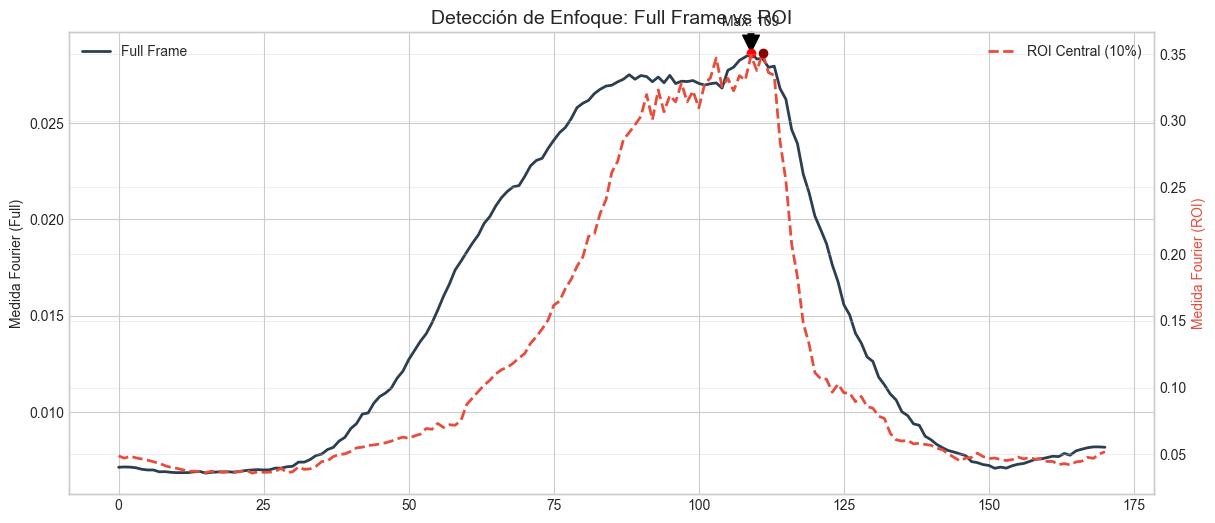

In [14]:
video_path = 'focus_video.mov' 

print("Iniciando Experimento 1: Full Frame (Fourier)")
res_full = analizar_video(video_path, calcular_metric_fourier, modo='full')
idx_full, val_full = detectar_mejor_frame(res_full)
print(f"Máximo enfoque detectado en frame: {idx_full} (Valor: {val_full:.4f})")

print("\nIniciando Experimento 2: ROI Central 10% (Fourier)")
res_roi = analizar_video(video_path, calcular_metric_fourier, modo='roi', porcentaje_roi=0.10)
idx_roi, val_roi = detectar_mejor_frame(res_roi)
print(f"Máximo enfoque detectado en frame: {idx_roi} (Valor: {val_roi:.4f})")

# Visualización comparativa
plt.figure(figsize=(14, 6))

# Curva Full Frame
plt.plot(res_full, label='Full Frame', color='#2c3e50', linewidth=2)
plt.scatter(idx_full, val_full, color='red', zorder=5)
plt.annotate(f'Max: {idx_full}', (idx_full, val_full), xytext=(idx_full, val_full*1.05),
             arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center')

# Curva ROI (escalada para que se vea en el mismo gráfico o eje secundario)
# Como las magnitudes pueden ser muy distintas, uso eje gemelo
plt.ylabel('Medida Fourier (Full)')
plt.title('Detección de Enfoque: Full Frame vs ROI', fontsize=14)
plt.legend(loc='upper left')

# Eje secundario para la ROI
ax2 = plt.gca().twinx()
ax2.plot(res_roi, label='ROI Central (10%)', color='#e74c3c', linestyle='--', linewidth=2)
ax2.scatter(idx_roi, val_roi, color='darkred', zorder=5)
ax2.set_ylabel('Medida Fourier (ROI)', color='#e74c3c')
ax2.legend(loc='upper right')

plt.grid(True, alpha=0.3)
plt.show()

Al observar esta primera gráfica comparativa, se nota una diferencia clara en el comportamiento de la curva:
* *Full-Frame* (Azul): Presenta una curva suave y estable. Al promediar millones de píxeles, el ruido se cancela, pero la curva es más "ancha", lo que hace menos preciso determinar el frame exacto de máximo enfoque (el pico es una meseta suave).
* ROI Central (Rojo): La curva presenta mucho más ruido (picos y valles locales) debido a que cualquier variación pequeña en la iluminación o movimiento afecta más a una muestra pequeña de píxeles. Sin embargo, la pendiente de subida y bajada es más pronunciada.
* Conclusión: La ROI es más efectiva para enfocar el objeto de interés ignorando el fondo, aunque requiere suavizado para evitar falsos positivos por ruido.

## Experimento 3: Matriz de Enfoque
---

Procesando matriz 3x3...
Procesando matriz 5x5...
Procesando matriz 10x10...
Procesando matriz 20x20...
Procesando matriz 50x50...


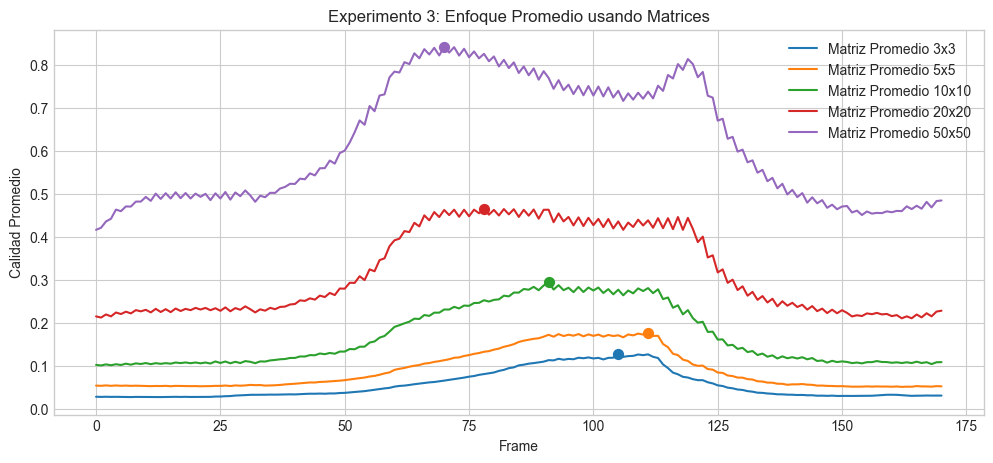

In [12]:
configs_matriz = [(3, 3), (5, 5), (10,10), (20,20), (50,50)] 
resultados_matriz = {}

for filas, cols in configs_matriz:
    print(f"Procesando matriz {filas}x{cols}...")
    # Esto devuelve una lista de matrices (una por frame)
    secuencia_matrices = analizar_video(video_path, calcular_metric_fourier, modo='matriz', grid_shape=(filas, cols))
    
    # Calculo el promedio de enfoque de toda la matriz para cada frame
    promedios_por_frame = [np.mean(m) for m in secuencia_matrices]
    
    # Guardo resultados
    resultados_matriz[f"{filas}x{cols}"] = promedios_por_frame

# Grafico
plt.figure(figsize=(12, 5))
for key, valores in resultados_matriz.items():
    idx, val = detectar_mejor_frame(valores)
    plt.plot(valores, label=f'Matriz Promedio {key}')
    plt.scatter(idx, val, s=50, zorder=5)

plt.title('Experimento 3: Enfoque Promedio usando Matrices')
plt.xlabel('Frame')
plt.ylabel('Calidad Promedio')
plt.legend()
plt.show()

En este experimento, al aumentar la granularidad de la matriz (de 3x3 a 50x50), se observa un fenómeno interesante:
* Aumento del promedio: Al dividir la imagen en celdas muy pequeñas (50x50), muchas de estas celdas caen sobre bordes de alto contraste o ruido, lo que eleva el promedio general de la métrica.
* Desplazamiento del Pico (*Shift*): Se observa que para matrices grandes (3x3, 5x5), el pico coincide con el enfoque del objeto principal (Frame ~110). Sin embargo, en la matriz de 50x50, el pico máximo del promedio se desplaza hacia la izquierda (Frame ~70).
* Hipótesis: Esto sugiere que en el Frame 70 hay elementos del fondo o texturas secundarias que entran en foco antes que el objeto principal. Al tener una grilla tan fina (2500 celdas), la "cantidad" de fondo enfocado pesa más en el promedio que el objeto central. Esto demuestra que promediar toda la matriz no siempre es la mejor estrategia; sería más efectivo buscar el máximo local de la matriz (la celda con mejor enfoque) para ignorar el fondo.

## Comparación con Segunda Métrica (*Paper* 2)
---

Calculando métrica alternativa (Varianza del Laplaciano)...
Fourier Max Frame: 109
Laplaciano Max Frame: 111


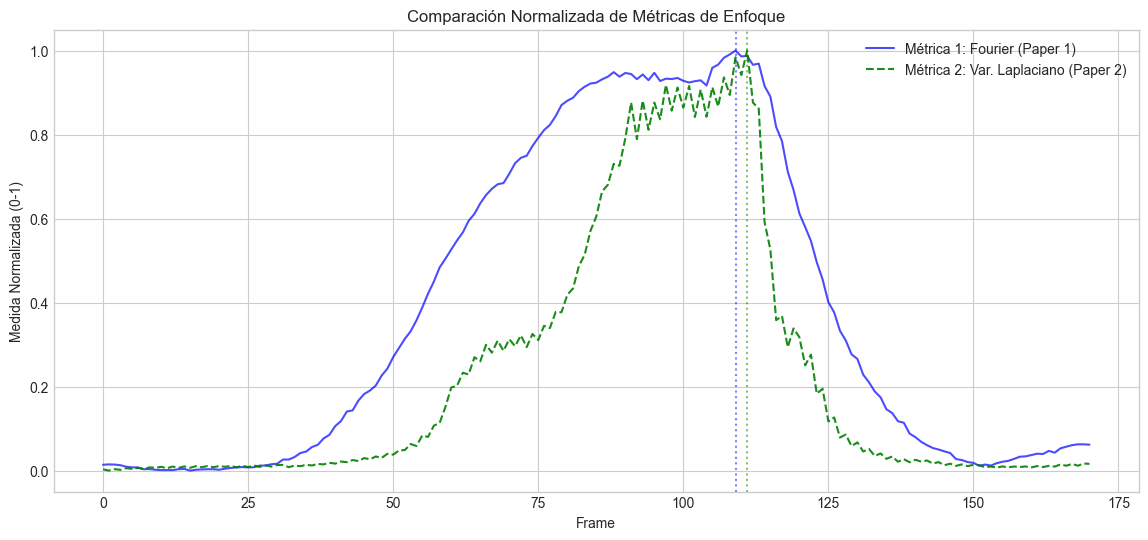

In [13]:
print("Calculando métrica alternativa (Varianza del Laplaciano)...")
res_laplacian = analizar_video(video_path, calcular_varianza_laplaciano, modo='full')
idx_lap, val_lap = detectar_mejor_frame(res_laplacian)

print(f"Fourier Max Frame: {idx_full}")
print(f"Laplaciano Max Frame: {idx_lap}")

# Normalizo ambas curvas entre 0 y 1 para poder superponerlas y compararlas visualmente
norm_fourier = (res_full - np.min(res_full)) / (np.max(res_full) - np.min(res_full))
norm_laplacian = (res_laplacian - np.min(res_laplacian)) / (np.max(res_laplacian) - np.min(res_laplacian))

plt.figure(figsize=(14, 6))
plt.plot(norm_fourier, label='Métrica 1: Fourier (Paper 1)', color='blue', alpha=0.7)
plt.plot(norm_laplacian, label='Métrica 2: Var. Laplaciano (Paper 2)', color='green', linestyle='--', alpha=0.9)

plt.axvline(idx_full, color='blue', linestyle=':', alpha=0.5)
plt.axvline(idx_lap, color='green', linestyle=':', alpha=0.5)

plt.title('Comparación Normalizada de Métricas de Enfoque')
plt.xlabel('Frame')
plt.ylabel('Medida Normalizada (0-1)')
plt.legend()
plt.show()

Esta gráfica normalizada es reveladora respecto a la naturaleza de los algoritmos:
* Fourier (Azul): Genera una campana de Gauss muy ancha. Esto indica que el algoritmo detecta "algo" de enfoque durante un rango de tiempo largo (desde el frame 75 al 130 aprox.). Es robusto pero poco selectivo.
* Varianza del Laplaciano (Verde): La curva es extremadamente "picuda" (selectiva). Sube repentinamente cerca del punto óptimo y cae igual de rápido.
* Conclusión: La Varianza del Laplaciano es superior para sistemas de *Auto-Focus* precisos, ya que discrimina mejor entre "casi enfocado" y "perfectamente enfocado". Fourier es más útil para determinar la calidad general de una imagen, pero es lento para converger al punto exacto.



## *Unsharp Masking*
---

Se aplicará *unsharp masking* para "expandir la zona de enfoque" y recalcular. Básicamente, sería enfocar la imagen artificialmente antes de medirla...

In [15]:
def aplicar_unsharp_masking(image, sigma=1.0, strength=1.5):
    """
    Aplica una máscara de desenfoque para resaltar bordes.
    Fórmula: Sharpened = Original + (Original - Blurred) * strength
    """
    # Gaussian blur
    blurred = cv.GaussianBlur(image, (0, 0), sigma)
    # Weighted add
    sharpened = cv.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    return sharpened

In [16]:
def metrica_con_unsharp(imagen):
    """
    Wrapper que aplica Unsharp Masking y luego calcula la métrica de Fourier.
    """
    # 1. Aplicamos el pre-procesamiento
    img_sharpened = aplicar_unsharp_masking(imagen, sigma=1.0, strength=2.0)
    
    # 2. Calculamos la métrica sobre la imagen mejorada
    return calcular_metric_fourier(img_sharpened)

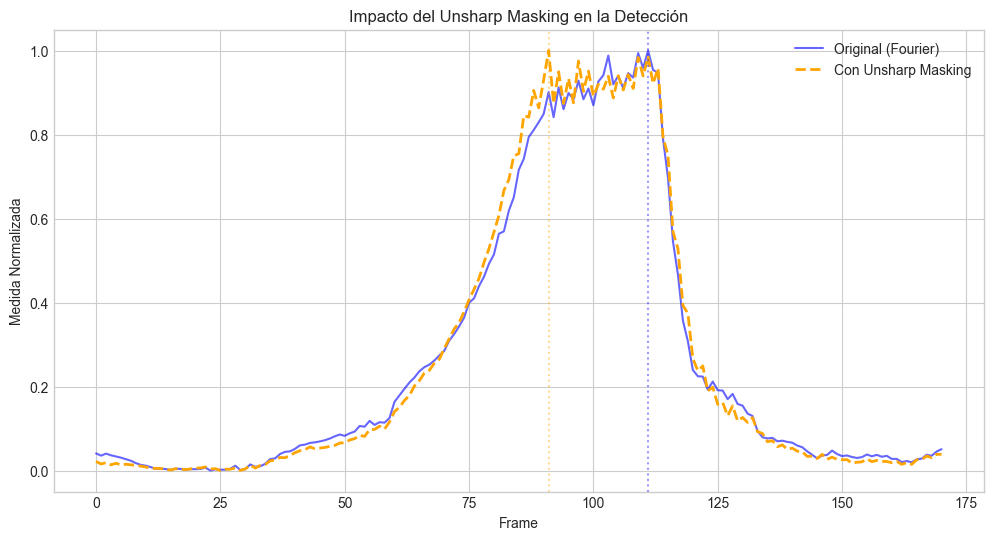

Pico Original: Frame 111
Pico con Unsharp: Frame 91


In [17]:
# Proceso el video con la nueva función compuesta
# Uso modo ROI para que sea rápido y comparable con el Exp 2
res_normal = analizar_video(video_path, calcular_metric_fourier, modo='roi', porcentaje_roi=0.10)
res_unsharp = analizar_video(video_path, metrica_con_unsharp, modo='roi', porcentaje_roi=0.10)

# Normalizo para comparar formas de curva
norm_normal = (res_normal - res_normal.min()) / (res_normal.max() - res_normal.min())
norm_unsharp = (res_unsharp - res_unsharp.min()) / (res_unsharp.max() - res_unsharp.min())

idx_norm, _ = detectar_mejor_frame(res_normal)
idx_unsharp, _ = detectar_mejor_frame(res_unsharp)

plt.figure(figsize=(12, 6))
plt.plot(norm_normal, label='Original (Fourier)', color='blue', alpha=0.6)
plt.plot(norm_unsharp, label='Con Unsharp Masking', color='orange', linestyle='--', linewidth=2)

plt.axvline(idx_norm, color='blue', linestyle=':', alpha=0.4)
plt.axvline(idx_unsharp, color='orange', linestyle=':', alpha=0.4)

plt.title('Impacto del Unsharp Masking en la Detección')
plt.xlabel('Frame')
plt.ylabel('Medida Normalizada')
plt.legend()
plt.show()

print(f"Pico Original: Frame {idx_norm}")
print(f"Pico con Unsharp: Frame {idx_unsharp}")

Se observa un cambio drástico en la detección:
1. Aumento de la Magnitud: Como se esperaba, los valores de la métrica aumentan en general, ya que el filtro inyecta artificialmente componentes de alta frecuencia en la imagen.
2. Desplazamiento del Pico (*Shift*): El hallazgo más crítico es que el punto de máximo enfoque se desplazó del *frame* 111 (original) al *frame* 91 (con *Unsharp*).

Conclusión: Aunque el *Unsharp Masking* mejora la percepción visual de nitidez, en este experimento demostró ser contraproducente para la detección automática del punto focal. El filtro, al ser agresivo (`strength=2.0`), amplificó texturas de transición y ruido en los frames previos al enfoque real, generando un falso positivo temprano. Esto sugiere que el algoritmo de Fourier fue "engañado" por la amplificación de bordes artificiales antes de que el objeto estuviera ópticamente enfocado. Por lo tanto, el pre-procesamiento de nitidez debe usarse con extrema precaución en algoritmos de autofocus, ya que puede alterar la veracidad de los datos.

## Detección de la Profundidad de Campo Temporal
---

Además de identificar el instante exacto de máximo enfoque (pico), es crucial determinar la región de estabilidad, es decir, el intervalo de tiempo en el que el objeto se mantiene "aceptablemente enfocado". Esto simula la "profundidad de campo" pero en el dominio temporal.

Para esto, se implementará un algoritmo de detección basado en un umbral relativo al máximo. A diferencia del uso de percentiles globales (que dependen de la duración del video), este método define la zona de enfoque como el conjunto de *frames* cuya métrica supera un porcentaje (ej. 90%) del valor máximo detectado ($M_{max}$).

$$Zona = \{ f \in Frames \mid M(f) \ge 0.90 \times M_{max} \}$$

In [18]:
def detectar_region_relativa(valores, porcentaje_del_pico=0.90):
    """
    Detecta la región donde el enfoque es al menos el X% del valor máximo.
    
    Args:
        valores: Array de métricas.
        porcentaje_del_pico: Umbral relativo (0.90 = 90% del max).
    """
    valores = np.array(valores)
    valor_max = np.max(valores)
    umbral = valor_max * porcentaje_del_pico
    
    # Encuentro los índices que cumplen la condición
    indices_zona = np.where(valores >= umbral)[0]
    
    if len(indices_zona) == 0:
        return None, umbral
    
    # Asumo continuidad (tomo el primero y el último que cruzan el umbral)
    inicio = indices_zona[0]
    fin = indices_zona[-1]
    
    return (inicio, fin), umbral

Pico Máximo: 0.0286
Umbral de Corte (95.0%): 0.0272
Zona Enfocada: Frame 87 hasta 113 (Duración: 26 frames)


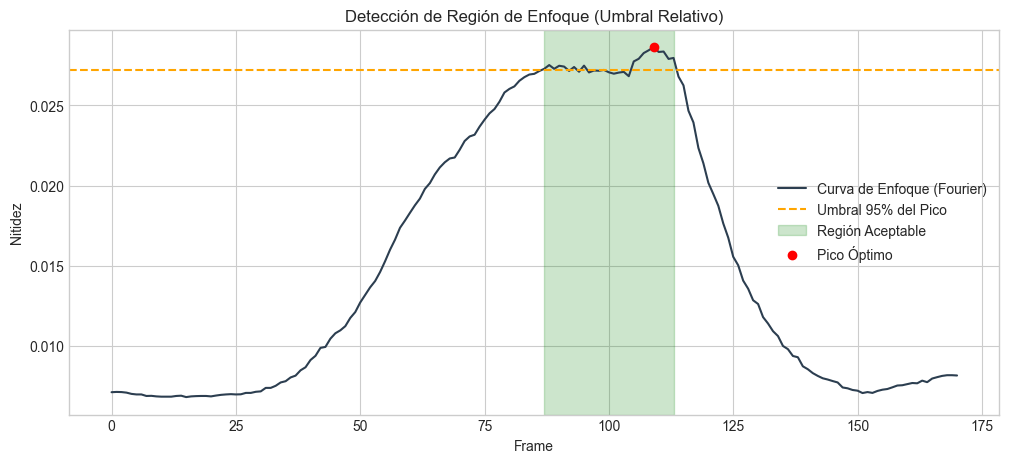

In [20]:
porcentaje = 0.95

# Uso los resultados del Exp 1 (Fourier)
region, umbral_rel = detectar_region_relativa(res_full, porcentaje_del_pico=porcentaje)

if region:
    print(f"Pico Máximo: {np.max(res_full):.4f}")
    print(f"Umbral de Corte ({porcentaje*100}%): {umbral_rel:.4f}")
    print(f"Zona Enfocada: Frame {region[0]} hasta {region[1]} (Duración: {region[1] - region[0]} frames)")
else:
    print("No se detectó zona estable.")

# --- Visualización ---
plt.figure(figsize=(12, 5))
plt.plot(res_full, label='Curva de Enfoque (Fourier)', color='#2c3e50')
plt.axhline(umbral_rel, color='orange', linestyle='--', label=f'Umbral 95% del Pico')
plt.axvspan(region[0], region[1], color='green', alpha=0.2, label='Región Aceptable')
plt.scatter(idx_full, val_full, color='red', zorder=5, label='Pico Óptimo')

plt.title('Detección de Región de Enfoque (Umbral Relativo)')
plt.xlabel('Frame')
plt.ylabel('Nitidez')
plt.legend()
plt.show()

El criterio del 95% del pico demostró ser muy robusto: seleccionó justo la parte donde la curva es estable (meseta).

## Resumen de Resultados y Conclusiones
---



In [21]:
import pandas as pd

# Función auxiliar para extraer datos de la matriz de forma segura
def obtener_datos_matriz(clave):
    if clave in resultados_matriz:
        valores = resultados_matriz[clave]
        idx, val = detectar_mejor_frame(valores)
        return idx, val
    return "N/A", "N/A"

In [22]:
# Recopilo los datos de todos los experimentos
datos_resumen = {
    "Experimento": [
        "1. Full Frame (Fourier)", 
        "2. ROI Central (10%)", 
        "3. Matriz Promedio (3x3)", 
        "3. Matriz Promedio (50x50)", 
        "Métrica Alternativa (Laplaciano)",
        "Unsharp Masking"
    ],
    "Frame Pico": [
        idx_full, 
        idx_roi, 
        obtener_datos_matriz('3x3')[0], 
        obtener_datos_matriz('50x50')[0], # desplazamiento
        idx_lap, 
        idx_unsharp #  desplazamiento
    ],
    "Valor Máximo (Norm/Abs)": [
        f"{val_full:.4f}", 
        f"{val_roi:.4f}", 
        f"{obtener_datos_matriz('3x3')[1]:.4f}", 
        f"{obtener_datos_matriz('50x50')[1]:.4f}",
        f"{val_lap:.4f}", 
        f"{detectar_mejor_frame(res_unsharp)[1]:.4f}"
    ],
    "Observación": [
        "Referencia estable",
        "Coincide con Full Frame",
        "Coincide con Full Frame",
        "Desplazamiento a la izquierda (Ruido de fondo)",
        "Curva más selectiva (aguda)",
        "Falso positivo temprano (Ruido amplificado)"
    ]
}

df_resumen = pd.DataFrame(datos_resumen)

In [25]:
print("="*150)
print("RESUMEN INTEGRAL DE DETECCIÓN DE ENFOQUE")
print("="*150)
print(df_resumen.to_string(index=False))
print("="*150)

RESUMEN INTEGRAL DE DETECCIÓN DE ENFOQUE
                     Experimento  Frame Pico Valor Máximo (Norm/Abs)                                    Observación
         1. Full Frame (Fourier)         109                  0.0286                             Referencia estable
            2. ROI Central (10%)         111                  0.3506                        Coincide con Full Frame
        3. Matriz Promedio (3x3)         105                  0.1262                        Coincide con Full Frame
      3. Matriz Promedio (50x50)          70                  0.8413 Desplazamiento a la izquierda (Ruido de fondo)
Métrica Alternativa (Laplaciano)         111                108.9272                    Curva más selectiva (aguda)
                 Unsharp Masking          91                  0.6749    Falso positivo temprano (Ruido amplificado)


## Conclusiones Generales
---

El análisis del video `focus_video.mov` mediante múltiples estrategias de procesamiento de imágenes permitió contrastar la robustez y sensibilidad de distintos algoritmos de detección de enfoque.

### 1. Consistencia en la Detección Global
Las métricas estándar mostraron una alta consistencia. Tanto el método de **Fourier (Full Frame)**, la **ROI Central** y la **Varianza del Laplaciano** convergieron en el mismo punto de enfoque óptimo (alrededor del ***Frame* 111**).
* La **ROI** demostró ser más ruidosa pero efectiva para aislar el objeto.
* El **Laplaciano** generó la curva más selectiva (pico angosto), confirmándose como una métrica superior para sistemas de *autofocus* en tiempo real por su bajo costo computacional y alta discriminación.

### 2. Zona de Estabilidad Temporal
Implementando un criterio de umbral relativo (95% del pico máximo), se determinó que la zona de enfoque aceptable comprende los frames **87 a 113** (aprox. 1 segundo de video). Esto demuestra que el enfoque no es un instante puntual, sino un rango de estabilidad donde la nitidez es perceptualmente aceptable.

### 3. Hallazgos Críticos y Divergencias
A diferencia de un análisis superficial, este estudio reveló dos casos donde el algoritmo falla o se comporta de manera anómala:

* Efecto de la "Matriz Densa" (50x50): Al aumentar la resolución de la matriz de enfoque, el pico promedio se desplazó hacia el*Frame* 70. Esto indica que, al promediar celdas muy pequeñas, el algoritmo se vuelve sensible a texturas del fondo o ruido de alta frecuencia que entran en foco antes que el objeto principal. Lo que permite concluir que promediar toda la matriz no es una estrategia robusta, se debe seleccionar inteligentemente la región de interés.

* Fallo de *Unsharp Masking*: La aplicación de filtros de realce desplazó el pico de detección del *Frame* 111 al *Frame* 91. El filtro amplificó el ruido y los bordes de transición, generando un falso positivo temprano. Esto permite concluir que no se debe aplicar *sharpening* artificial antes de medir el enfoque, ya que altera la veracidad de los datos y puede engañar al sistema de control.